## Imagery layers and Raster analysis

### Access Landsat imagery

In [1]:
from arcgis.gis import GIS

In [2]:
gis = GIS('https://python.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

In [3]:
landsat_item = gis.content.search('title: Multispectral Landsat',
                                  'Imagery Layer', outside_org=True) 

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri_livingatlas>
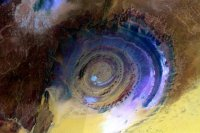

In [4]:
landsat_item

### View Landsat imagery layer item description

In [75]:
from IPython.display import HTML
HTML(landsat_item.description)

Band Num.


### Access the layers available with the Landsat Imagery Layer item

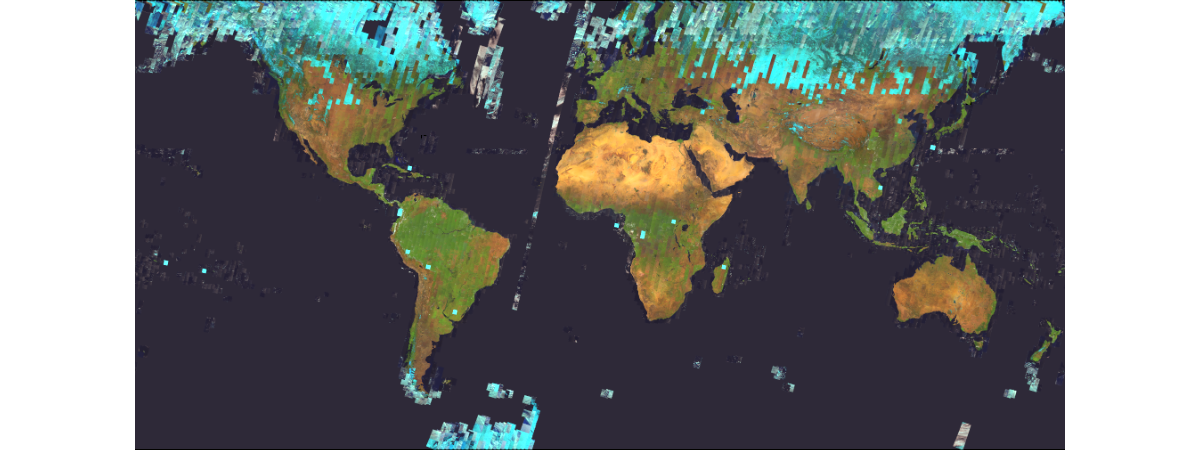

In [6]:
landsat = landsat_item.layers[0]
landsat

## Explore different wavelength bands

In [7]:
import pandas as pd

In [69]:
pd.DataFrame(landsat.key_properties()['BandProperties'])

,BandIndex,BandName,DatasetTag,WavelengthMax,WavelengthMin
0,0,CoastalAerosol,MS,450,430
1,1,Blue,MS,510,450
2,2,Green,MS,590,530
3,3,Red,MS,670,640
4,4,NearInfrared,MS,880,850
5,5,ShortWaveInfrared_1,MS,1650,1570
6,6,ShortWaveInfrared_2,MS,2290,2110
7,7,Cirrus,MS,1380,1360


## Visualize the layer in the map widget

In [76]:
m = gis.map('Redlands, CA')
m

In [77]:
m.add_layer(landsat)

In [79]:
import time

for rasterfunc in landsat.properties.rasterFunctionInfos:
    print (rasterfunc.name)
    m.add_layer(apply(landsat, rasterfunc.name))
    time.sleep(2)

Agriculture with DRA
Bathymetric with DRA
Color Infrared with DRA
Geology with DRA
Natural Color with DRA
Short-wave Infrared with DRA
Agriculture
Bathymetric
Color Infrared
Geology
Natural Color
Short-wave Infrared
NDVI Colorized
Normalized Difference Moisture Index Colorized
NDVI Raw
NBR Raw
None


In [12]:
from arcgis.raster.functions import apply

In [14]:
m = gis.map('Redlands, CA')
m.add_layer(color_infrared)
m

### Interactive raster processing in Jupyter Notebook

In [13]:
color_infrared = apply(landsat, 'Color Infrared with DRA')

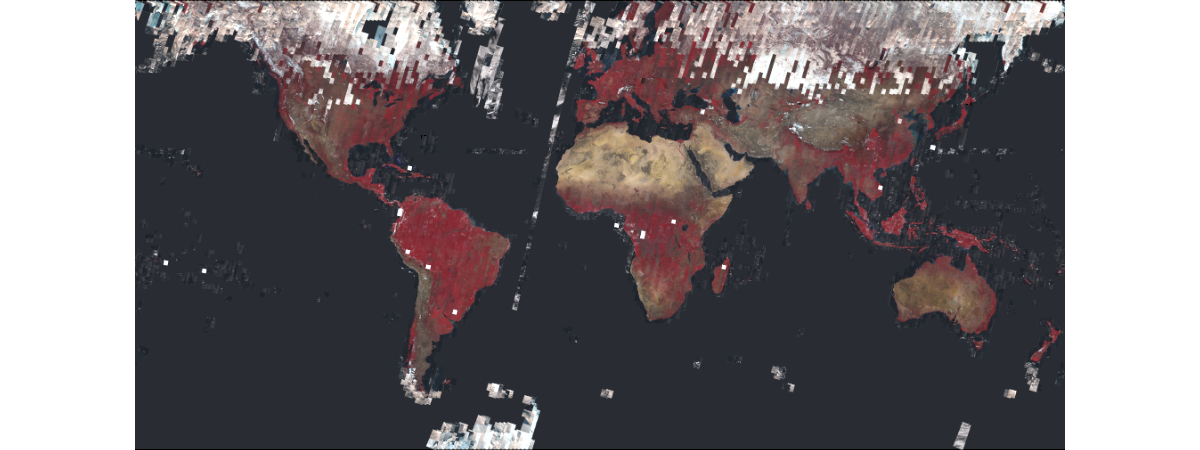

In [15]:
color_infrared 

### Setting an area of interest

In [16]:
from arcgis.geocoding import geocode
area = geocode('Redlands, CA', out_sr=landsat.properties.spatialReference)[0]

In [17]:
color_infrared.extent = area['extent']

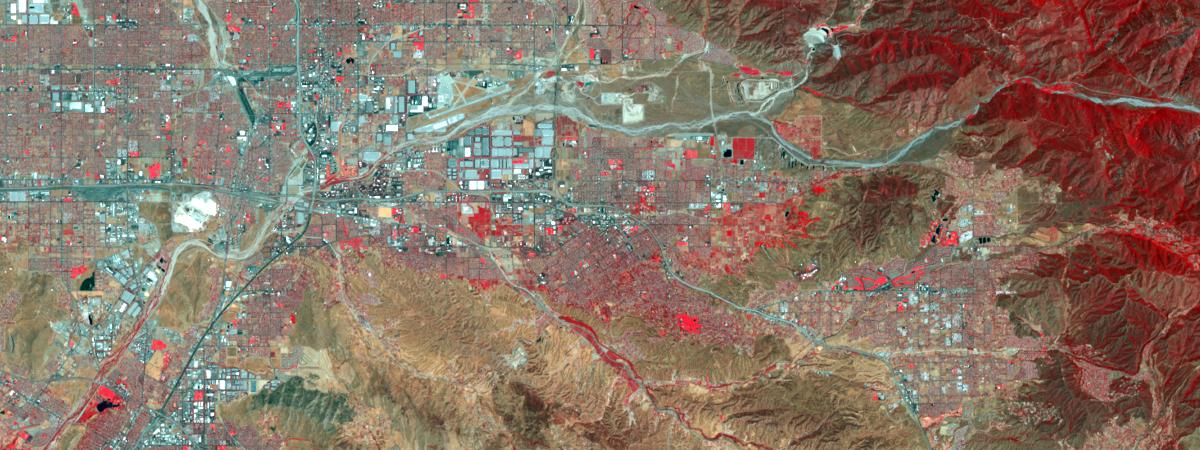

In [18]:
color_infrared

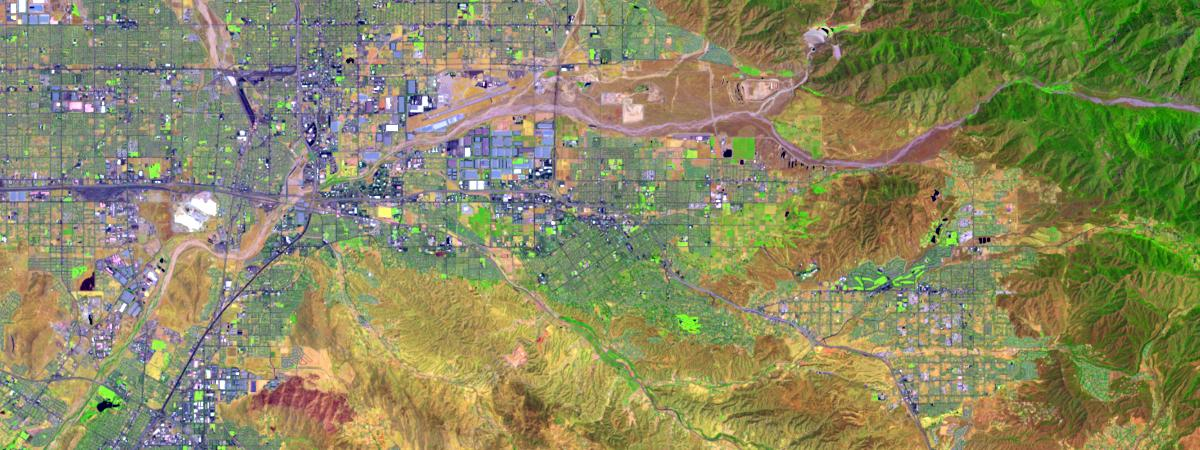

In [19]:
landsat.extent = area['extent']
landsat

## Exporting Images from Imagery Layer

In [20]:
from IPython.display import Image

In [21]:
img = landsat.export_image(bbox=area['extent'], size=[1200,450], f='image')

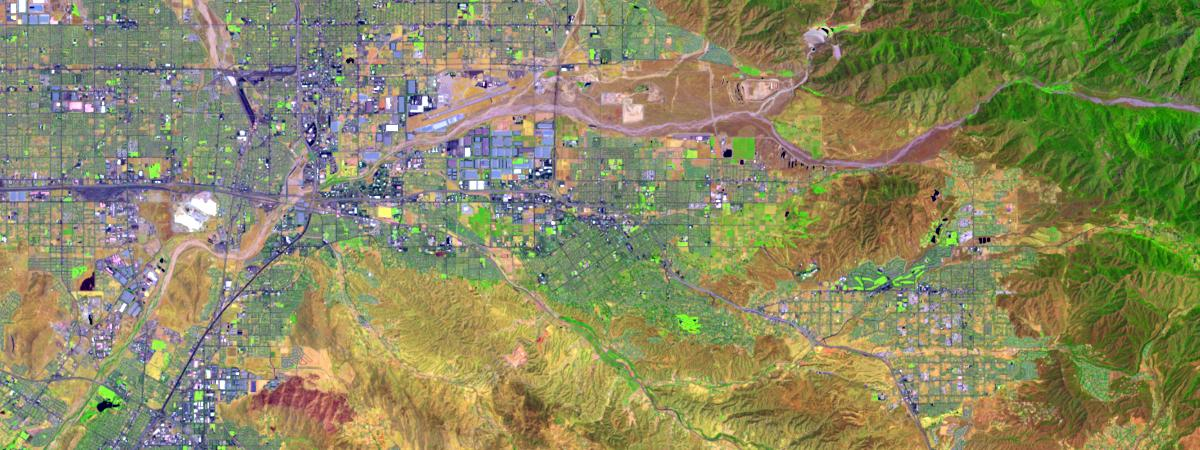

In [22]:
Image(img)

In [23]:
savedimg = landsat.export_image(bbox=area['extent'], size=[1200,450], 
                                f='image', save_folder='.', 
                                save_file='img.jpg')

In [24]:
savedimg

'.\\img.jpg'

In [25]:
from IPython.display import Image

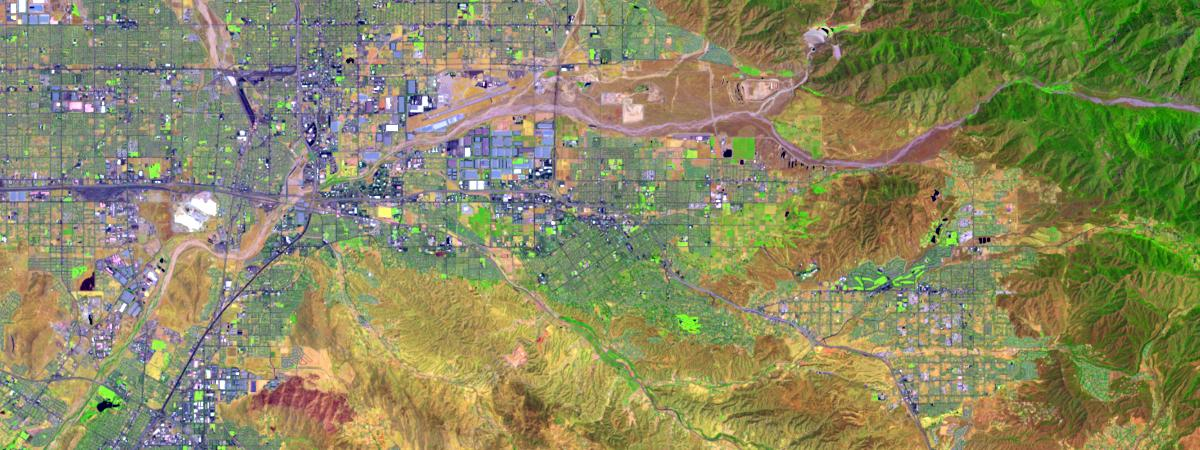

In [80]:
Image(filename=savedimg, width=1200, height=450)

### Exporting images with raster function applied to them

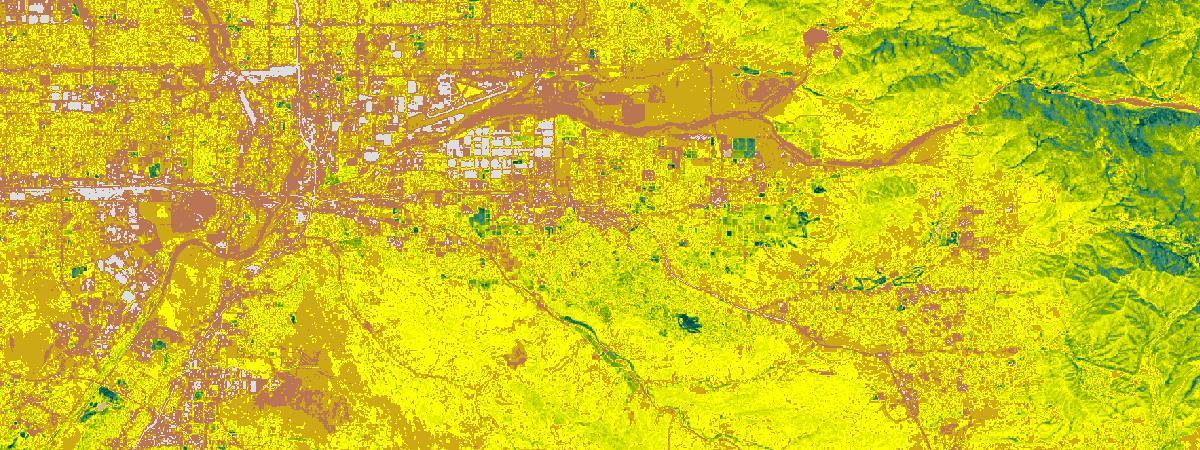

In [81]:
ndvi_colorized = apply(landsat, 'NDVI Colorized')
ndvi_colorized

## Extracting custom bands

In [31]:
from arcgis.raster.functions import stretch, extract_band

In [32]:
naturalcolor = stretch(extract_band(landsat, [3,2,1]), 
                    stretch_type='percentclip', min_percent=0.1, max_percent=0.1, 
                       gamma=[1, 1, 1], dra=True)

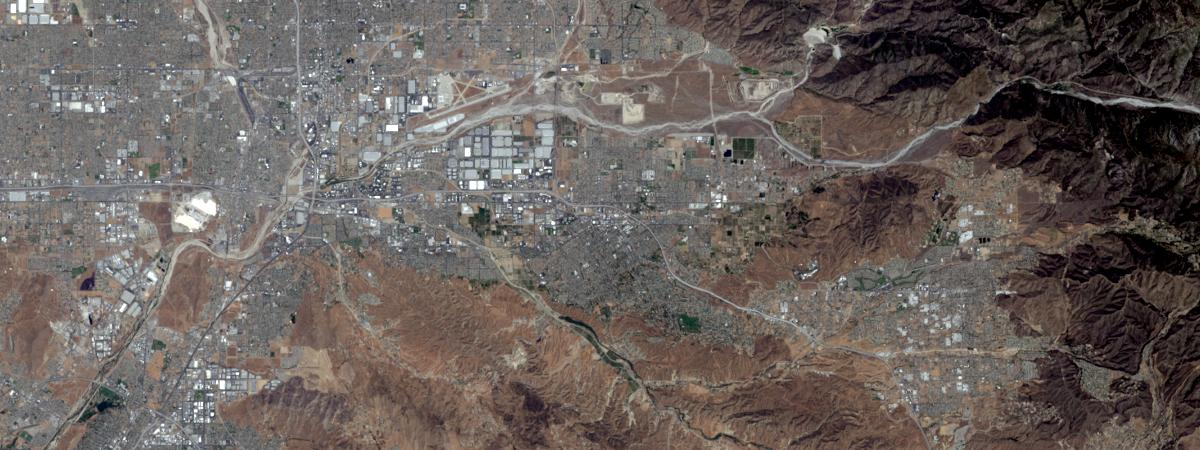

In [82]:
naturalcolor

# Image Attributes

In [34]:
import arcgis
g = arcgis.geometry.Geometry(area['extent'])

In [85]:
samples = landsat.get_samples?

In [ ]:
samples = landsat.get_samples

In [83]:
samples[0]

{'attributes': {'AcquisitionDate': 1499192516579,
  'Category': 1,
  'CloudCover': 0,
  'GroupName': 'LC80400362017185LGN00_MTL',
  'OBJECTID': 518244,
  'SunAzimuth': 115.1925,
  'SunElevation': 67.16952},
 'location': {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
  'x': -13051664.00092773,
  'y': 4044907.967502277},
 'locationId': 0,
 'rasterId': 518244,
 'resolution': 30,
 'value': '12533 12157 12697 14078 21149 20288 15484 5073'}

In [84]:
import datetime
value = samples[0]['attributes']['AcquisitionDate']
datetime.datetime.fromtimestamp(value /1000).strftime("Acquisition Date: %d %b, %Y")

'Acquisition Date: 04 Jul, 2017'

In [38]:
pd.DataFrame(samples[0]['attributes'], index=[0])

,AcquisitionDate,Category,CloudCover,GroupName,OBJECTID,SunAzimuth,SunElevation
0,1499192516579,1,0,LC80400362017185LGN00_MTL,518244,115.1925,67.16952


## Spectral profile from the sampled values at a location

In [86]:
m = gis.map('Redlands, CA')
m

In [87]:
m.add_layer(landsat)

In [88]:
from bokeh.models import Range1d
from bokeh.plotting import figure, show, output_notebook
from IPython.display import clear_output
output_notebook()

def get_samples(mw, g):
    clear_output()
    m.draw(g)
    samples = landsat.get_samples(g, pixel_size=30)
    values = samples[0]['value']
    vals = [float(int(s)/100000) for s in values.split(' ')]
    
    x = ['1','2', '3', '4', '5', '6', '7', '8']
    y = vals
    p = figure(title="Spectral Profile", x_axis_label='Spectral Bands', y_axis_label='Data Values', width=600, height=300)
    p.line(x, y, legend="Selected Point", line_color="red", line_width=2)
    p.circle(x, y, line_color="red", fill_color="white", size=8)
    p.y_range=Range1d(0, 1.0)

    show(p)
    
print('Click anywhere on the map to plot the spectral profile for that location.')
m.on_click(get_samples)

Loading BokehJS ...

Click anywhere on the map to plot the spectral profile for that location.


# Clipping to an area of interest

In [42]:
from arcgis.geometry import Geometry, buffer 

In [43]:
poly = buffer(geometries=[Geometry(area['location'])],
              in_sr=102100, distances=6000, unit='esriMeters')[0]

In [44]:
from arcgis.raster.functions import clip

In [45]:
redclip = clip(landsat, poly)

In [89]:
m = gis.map('Redlands, CA')

In [90]:
m

In [91]:
m.add_layer(redclip)

## Select images by where clause, geometry and time range

In [92]:
selected = landsat.filter_by(where="(Category = 1) AND (CloudCover <=0.10) AND (WRS_Row = 36)", 
                   geometry=arcgis.geometry.filters.intersects(area['extent']))

In [93]:
fs = selected.query(out_fields="AcquisitionDate, GroupName, Best, CloudCover, WRS_Row, Month, Name", 
              return_geometry=True,
              return_distinct_values=False,
              order_by_fields="AcquisitionDate")

In [94]:
df = fs.df
df.head()

,AcquisitionDate,Best,CloudCover,GroupName,Month,Name,OBJECTID,Shape_Area,Shape_Length,WRS_Row,SHAPE
0,233798400000,95957036,-0.01,p043r036_2x19770530,5,p043r036_2dm19770530_z11_MS,560200,5.026523e+10,897574.641900,36,"{'rings': [[[-12889114.8652, 4207339.365500003..."
1,642038400000,91960036,-0.01,p040r036_5x19900507,5,p040r036_5dt19900507_z11_MS,552245,4.694317e+10,867257.252743,36,"{'rings': [[[-12902153.7239, 4064989.857699997..."
2,956534400000,88960036,0.00,p040r036_7x20000424,4,p040r036_7dt20000424_z11_MS,542985,4.600983e+10,858608.456217,36,"{'rings': [[[-12872961.873599999, 4197538.7916..."
3,1116892800000,79960036,0.00,L7040036_03620050524,5,L72040036_03620050524_MS,534024,4.766887e+10,874086.578684,36,"{'rings': [[[-12867140.4332, 4198647.7443], [-..."
4,1242000000000,72960036,0.00,L5040036_03620090511,5,L5040036_03620090511_MS,522124,4.781355e+10,875674.823359,36,"{'rings': [[[-12862615.619800001, 4191651.0291..."


Looking at the shape of the dataframe we see that 46 scenes match the specified criteria:

In [52]:
df.shape

(47, 11)

The footprints of the rasters matching the criteria can be drawn using the map widget:

In [96]:
df['Time'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df['Time'].tail(10)

37   2016-10-21 18:22:29.983
38   2016-11-06 18:22:29.434
39   2016-11-22 18:22:29.754
40   2017-01-25 18:22:14.902
41   2017-03-14 18:21:52.988
42   2017-04-15 18:21:36.321
43   2017-05-01 18:21:25.794
44   2017-06-02 18:21:46.279
45   2017-06-18 18:21:52.739
46   2017-07-04 18:21:56.579
Name: Time, dtype: datetime64[ns]

### Resolving overlapping pixels in selected rasters

In [54]:
m = gis.map('Redlands, CA', 7)
display(m)
m.add_layer(selected.last())

In [55]:
m = gis.map('Redlands, CA', 7)
display(m)
m.add_layer(selected.first())

# Change Detection

In [56]:
old = landsat.filter_by('OBJECTID=1139')

In [57]:
new = landsat.filter_by('OBJECTID=463490')

## Difference Image

Difference Image mode illustrates all the changes in NDVI (vegeration index) between the two dates:

increases are shown in green, and decreases are shown in magenta. 

In [58]:
from arcgis.raster.functions import *

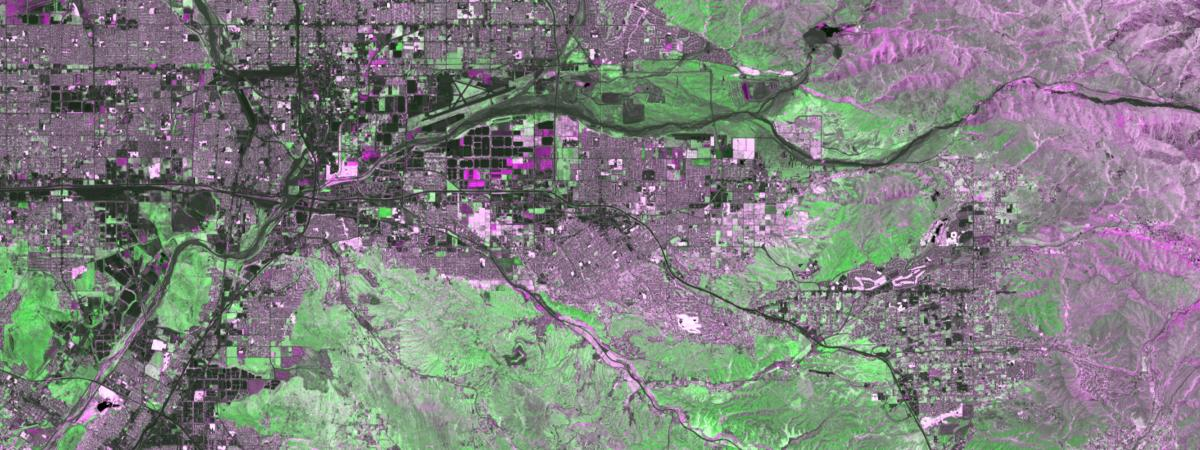

In [97]:
diff = stretch(composite_band([ndvi(old, '5 4'),
                               ndvi(new, '5 4'),
                               ndvi(old, '5 4')]), 
                               stretch_type='stddev',  num_stddev=3, min=0, max=255, dra=True, astype='u8')
diff

### Applying a threshold mask

The difference can also be computed using map algebra, as shown below:

In [98]:
ndvi_diff = ndvi(new, '5 4') - ndvi(old, '5 4')

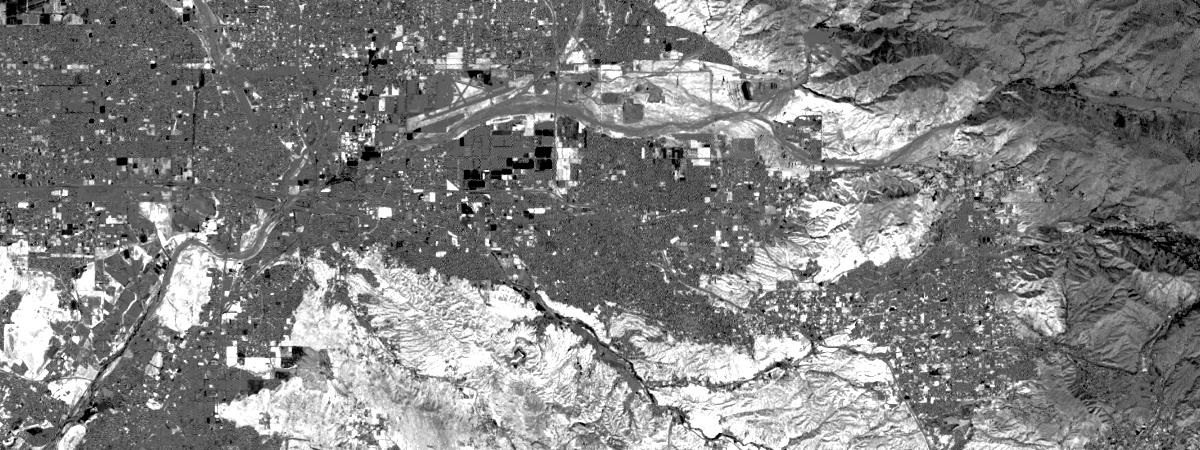

In [61]:
ndvi_diff

However, in the image above is hard to visualize in which areas the vegetation index changed by a specified threshold. The example below renders the areas where the change is above the specified threshold and renders it using a green color:

In [62]:
threshold_val = 0.1

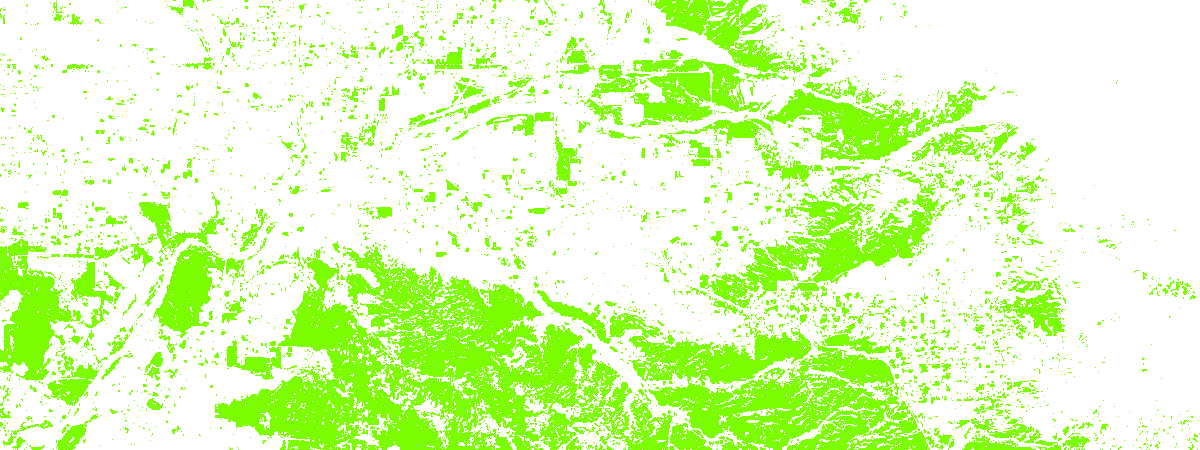

In [99]:
masked = colormap(remap(ndvi_diff, 
                        input_ranges=[threshold_val, 1], 
                        output_values=[1], 
                        no_data_ranges=[-1, threshold_val], astype='u8'), 
                  colormap=[[1, 124, 252, 0]], astype='u8')

Image(masked.export_image(bbox=area['extent'], size=[1200,450], f='image'))

## Visualize ndvi change

In [100]:
m = gis.map('Redlands, CA')
m

In [101]:
m.add_layer(diff)

In [102]:
m.add_layer(masked) 

### Persisting your analysis for visualizaion or analysis